# AAI-521 Group 6 Group Project

# herpeton

## Colab Friendly Notebook

### 1 Environment Setup

In [1]:
#@title Setup for TPU
print("Installing torch_xla and torchvision...")
!pip install torch_xla torchvision -f https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla/torch_xla-*.whl

import torch_xla.core.xla_model as xm
import torch

# Configure the device
try:
    # Attempt to get TPU device
    device = xm.xla_device()
    print(f"Device: {device} (TPU)")
except RuntimeError:
    # Fallback to CUDA if TPU is not available
    if torch.cuda.is_available():
        device = torch.device("cuda")
        print(f"Device: {device} (CUDA)")
    else:
        # Fallback to CPU if neither TPU nor CUDA is available
        device = torch.device("cpu")
        print(f"Device: {device} (CPU)")

# Verify device setup
print(f"Current device: {device}")

Installing torch_xla and torchvision...
Looking in links: https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla/torch_xla-*.whl


/tmp/ipython-input-712673675.py:10: DeprecationWarning: Use torch_xla.device instead
  device = xm.xla_device()


Device: xla:0 (TPU)
Current device: xla:0


In [9]:
#@title 1a) Environment Setup
import pandas as pd
import numpy as np
import hashlib
import io
import os
import sys
from collections import Counter, defaultdict
from dataclasses import dataclass
from typing import Dict, Iterable, Optional, Tuple

import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
!pip install imagehash
import imagehash
from tqdm import tqdm

import matplotlib.pyplot as plt
# Show plots inline
%matplotlib inline

!pip install squarify > /dev/null
import squarify

!pip install plotly > /dev/null
import plotly.express as px

!pip install wordcloud > /dev/null
from wordcloud import WordCloud

from PIL import Image, UnidentifiedImageError
from tqdm.auto import tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.7/296.7 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 142.9 MB/s eta 0:00:00


In [10]:
#@title 1b) Mount Google Drive
CURATE_TO_DRIVE = True

if CURATE_TO_DRIVE:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    BASE_OUT = "/content/drive/MyDrive/herpeton/data/biotrove_train"
else:
    BASE_OUT = "/content/herpeton"

os.makedirs(BASE_OUT, exist_ok=True)

# Controls to keep runtime reasonable
MAX_RECORDS = 15000          # hard cap across the stream (increase if you have time/compute)
SAMPLE_PER_SPECIES = 50      # images per species to collect/curate/EDA
REPORT_DIR = os.path.join(BASE_OUT, "_reports")
os.makedirs(REPORT_DIR, exist_ok=True)

print(f"Output base: {BASE_OUT}")
print(f"Reports   : {REPORT_DIR}")
print(f"Limits    : MAX_RECORDS={MAX_RECORDS}, SAMPLE_PER_SPECIES={SAMPLE_PER_SPECIES}")

Mounted at /content/drive
Output base: /content/drive/MyDrive/herpeton/data/biotrove_train
Reports   : /content/drive/MyDrive/herpeton/data/biotrove_train/_reports
Limits    : MAX_RECORDS=15000, SAMPLE_PER_SPECIES=50


### 5 Models

In [33]:
#@title 5a) Environment Setup
!pip -q install timm

import os
import math
from typing import Dict, List, Tuple

import numpy as np
import pandas as pd
from PIL import Image

import torch
from torch import nn
from torch import amp
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import LambdaLR
from torch.cuda.amp import GradScaler, autocast

import torchvision.transforms as T

from typing import Optional

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

import timm
from tqdm.auto import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cpu


In [34]:
#@title 5b) Mount Drive & Load Metadata
from google.colab import drive

drive.mount("/content/drive", force_remount=True)

metadata_path = (
    "/content/drive/MyDrive/herpeton//data/biotrove_train/reptilia_dataset_processed.csv"
)

BASE_PATH = "/content/drive/MyDrive/herpeton//data/biotrove_train"
IMG_DIR = os.path.join(BASE_PATH, "images_reptilia")


df = pd.read_csv(metadata_path)
print("Metadata shape:", df.shape)
df.head()

Mounted at /content/drive
Metadata shape: (18750, 16)


,photo_id,scientificName,kingdom,phylum,class,order,family,genus,species,common_name,taxonRank,photo_url,split,image_path_fixed,width,height
0,483440,Agkistrodon laticinctus,Animalia,Chordata,Reptilia,Squamata,Viperidae,Agkistrodon,laticinctus,Broad-banded Copperhead,species,http://inaturalist-open-data.s3.amazonaws.com/...,train,/content/drive/MyDrive/herpeton/data/biotrove_...,480.0,358.0
1,345778,Sceloporus uniformis,Animalia,Chordata,Reptilia,Squamata,Phrynosomatidae,Sceloporus,uniformis,Yellow-backed Spiny Lizard,species,http://inaturalist-open-data.s3.amazonaws.com/...,train,/content/drive/MyDrive/herpeton/data/biotrove_...,500.0,353.0
2,181353,Pantherophis spiloides,Animalia,Chordata,Reptilia,Squamata,Colubridae,Pantherophis,spiloides,Gray Ratsnake,species,http://inaturalist-open-data.s3.amazonaws.com/...,train,/content/drive/MyDrive/herpeton/data/biotrove_...,373.0,500.0
3,35083,Lampropeltis triangulum,Animalia,Chordata,Reptilia,Squamata,Colubridae,Lampropeltis,triangulum,Eastern Milksnake,species,http://inaturalist-open-data.s3.amazonaws.com/...,train,/content/drive/MyDrive/herpeton/data/biotrove_...,500.0,376.0
4,261176,Imantodes cenchoa,Animalia,Chordata,Reptilia,Squamata,Colubridae,Imantodes,cenchoa,Blunthead Tree Snake,species,http://inaturalist-open-data.s3.amazonaws.com/...,train,/content/drive/MyDrive/herpeton/data/biotrove_...,500.0,337.0


In [ ]:
#@title 5c) Encode Labels & Train/Val Split
# Use 'species' as label
assert "species" in df.columns, "Expected 'species' column in metadata."
assert "image_path_fixed" in df.columns, "Expected 'image_path_fixed' column with image paths."

# Encode species as integer labels
df["label_id"], label_names = pd.factorize(df["species"])
num_classes = len(label_names)
print("Number of classes:", num_classes)

# Split data using the 'split' column
train_df = df[df["split"] == "train"].copy()
val_df = df[df["split"] == "val"].copy()
test_df = df[df["split"] == "test"].copy()

# Filter out rows with NaN in 'image_path_fixed' column for each split
train_df = train_df.dropna(subset=['image_path_fixed']).reset_index(drop=True)
val_df = val_df.dropna(subset=['image_path_fixed']).reset_index(drop=True)
test_df = test_df.dropna(subset=['image_path_fixed']).reset_index(drop=True)

print("Train size:", len(train_df))
print("Val size:", len(val_df))
print("Test size:", len(test_df))

Number of classes: 528
Train size: 13879
Val size: 1982
Test size: 1753


In [ ]:
#@title 5d) Dataset & Transforms
class ReptiliaDataset(Dataset):
    def __init__(self, df: pd.DataFrame, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self) -> int:
        return len(self.df)

    def __getitem__(self, idx: int):
        row = self.df.iloc[idx]
        img_path = row["image_path_fixed"]
        label = int(row["label_id"])

        img = Image.open(img_path).convert("RGB")

        if self.transform is not None:
            img = self.transform(img)

        return img, label


# Image size compatible with ResNet50
image_size = 224

train_transform = T.Compose(
    [
        T.Resize((image_size, image_size)),
        T.RandomHorizontalFlip(),
        T.RandomRotation(10),
        T.ColorJitter(
            brightness=0.2,
            contrast=0.2,
            saturation=0.2,
            hue=0.02,
        ),
        T.ToTensor(),
        T.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225],
        ),
    ]
)

val_transform = T.Compose(
    [
        T.Resize((image_size, image_size)),
        T.ToTensor(),
        T.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225],
        ),
    ]
)

train_dataset = ReptiliaDataset(train_df, transform=train_transform)
val_dataset = ReptiliaDataset(val_df, transform=val_transform)
test_dataset = ReptiliaDataset(test_df, transform=val_transform)

In [ ]:
#@title 5e) Dataloaders

# Requested batch size:
requested_batch_size = 64

BATCH_SIZE = requested_batch_size

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    pin_memory=True,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=True,
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=True,
)
len(train_loader), len(val_loader), len(test_loader)


(217, 31, 28)

In [ ]:
from torch.optim.lr_scheduler import LambdaLR
from torch import amp

def create_warmup_scheduler(optimizer, warmup_steps: int):
    """
    Linear warmup from 0 -> 1 over warmup_steps, then stays at 1.
    """
    def lr_lambda(step: int):
        if step < warmup_steps:
            return float(step) / float(max(1, warmup_steps))
        return 1.0

    return LambdaLR(optimizer, lr_lambda)


def train_one_epoch(
    model: nn.Module,
    loader: DataLoader,
    optimizer: torch.optim.Optimizer,
    scheduler: Optional[LambdaLR],
    epoch: int,
    total_steps_done: int,
    use_bf16: bool = True,
) -> Tuple[int, float]:
    model.train()
    running_loss = 0.0
    n_batches = 0

    # Check bf16 capability
    can_bf16 = use_bf16 and torch.cuda.is_available() and torch.cuda.is_bf16_supported()

    scaler = amp.GradScaler("cuda", enabled=not can_bf16)

    for images, labels in tqdm(loader, desc=f"Train Epoch {epoch}"):
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)

        if can_bf16:

            with amp.autocast("cuda", dtype=torch.bfloat16):
                outputs = model(images)
                loss = nn.functional.cross_entropy(outputs, labels)
        else:
            # fp16 / default autocast on CUDA
            with amp.autocast("cuda"):
                outputs = model(images)
                loss = nn.functional.cross_entropy(outputs, labels)

        # backward + step
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        if scheduler is not None:
            scheduler.step()

        running_loss += loss.item()
        n_batches += 1
        total_steps_done += 1

    avg_loss = running_loss / max(1, n_batches)
    print(f"Epoch {epoch} - Train Loss: {avg_loss:.4f}")
    return total_steps_done, avg_loss



@torch.no_grad()
def evaluate(model: nn.Module, loader: DataLoader) -> Tuple[float, float]:
    model.eval()
    all_preds: List[int] = []
    all_labels: List[int] = []
    total_loss = 0.0
    num_batches = 0

    for images, labels in tqdm(loader, desc="Eval"):
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        outputs = model(images)
        loss = nn.functional.cross_entropy(outputs, labels)
        preds = outputs.argmax(dim=1)

        all_preds.extend(preds.cpu().numpy().tolist())
        all_labels.extend(labels.cpu().numpy().tolist())
        total_loss += loss.item()
        num_batches += 1

    acc = accuracy_score(all_labels, all_preds)
    avg_loss = total_loss / max(1, num_batches)
    return acc, avg_loss

In [ ]:
#@title 5g) Hyperparameters
EPOCHS = 40
LR = 0.0005
WEIGHT_DECAY = 0.0004
WARMUP_STEPS = 5000  # global steps

### 5.1 - Model 1  - ResNet50 Baseline

In [ ]:
from google.colab import output
output.no_vertical_scroll()

#@title ResNet50 Model


# Build ResNet50 (using timm for consistency)
model_resnet = timm.create_model(
    "resnet50",
    pretrained=True,
    num_classes=num_classes,
)
model_resnet.to(device)

optimizer_resnet = AdamW(
    model_resnet.parameters(),
    lr=LR,
    weight_decay=WEIGHT_DECAY,
)

# Steps per epoch = batches in train loader
steps_per_epoch = len(train_loader)
total_training_steps = EPOCHS * steps_per_epoch
print("Steps per epoch:", steps_per_epoch)
print("Total training steps:", total_training_steps)

scheduler_resnet = create_warmup_scheduler(
    optimizer_resnet,
    warmup_steps=WARMUP_STEPS,
)

history_resnet = {"epoch": [], "val_acc": [], "val_loss": [], "train_loss": []}

global_step = 0

for epoch in range(1, EPOCHS + 1):
    global_step, train_loss = train_one_epoch(
        model_resnet,
        train_loader,
        optimizer_resnet,
        scheduler_resnet,
        epoch,
        total_steps_done=global_step,
        use_bf16=True,
    )

    val_acc, val_loss = evaluate(model_resnet, val_loader)
    history_resnet["epoch"].append(epoch)
    history_resnet["val_acc"].append(val_acc)
    history_resnet["val_loss"].append(val_loss)
    history_resnet["train_loss"].append(train_loss)

    print(f"Epoch {epoch} - Val Accuracy: {val_acc:.4f} - Val Loss: {val_loss:.4f}")

<IPython.core.display.Javascript object>

Steps per epoch: 217
Total training steps: 8680


Train Epoch 1:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 1 - Train Loss: 6.2665


Eval:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 1 - Val Accuracy: 0.0025 - Val Loss: 6.2586


Train Epoch 2:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 2 - Train Loss: 6.2364


Eval:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 2 - Val Accuracy: 0.0091 - Val Loss: 6.2174


Train Epoch 3:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 3 - Train Loss: 6.1430


Eval:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 3 - Val Accuracy: 0.0348 - Val Loss: 6.0490


Train Epoch 4:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 4 - Train Loss: 5.7041


Eval:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 4 - Val Accuracy: 0.0802 - Val Loss: 5.1913


Train Epoch 5:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 4.7937


Eval:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 5 - Val Accuracy: 0.1241 - Val Loss: 4.3592


Train Epoch 6:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 6 - Train Loss: 3.9650


Eval:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 6 - Val Accuracy: 0.1963 - Val Loss: 3.7991


Train Epoch 7:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 7 - Train Loss: 3.2957


Eval:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 7 - Val Accuracy: 0.2477 - Val Loss: 3.3763


Train Epoch 8:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 8 - Train Loss: 2.7288


Eval:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 8 - Val Accuracy: 0.2926 - Val Loss: 3.1331


Train Epoch 9:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 9 - Train Loss: 2.2512


Eval:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 9 - Val Accuracy: 0.3350 - Val Loss: 2.9266


Train Epoch 10:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 10 - Train Loss: 1.8263


Eval:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 10 - Val Accuracy: 0.3567 - Val Loss: 2.8197


Train Epoch 11:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 11 - Train Loss: 1.4728


Eval:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 11 - Val Accuracy: 0.3764 - Val Loss: 2.7167


Train Epoch 12:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 12 - Train Loss: 1.1537


Eval:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 12 - Val Accuracy: 0.3885 - Val Loss: 2.7009


Train Epoch 13:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 13 - Train Loss: 0.8953


Eval:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 13 - Val Accuracy: 0.4001 - Val Loss: 2.6987


Train Epoch 14:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 14 - Train Loss: 0.6640


Eval:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 14 - Val Accuracy: 0.4097 - Val Loss: 2.7158


Train Epoch 15:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 15 - Train Loss: 0.4899


Eval:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 15 - Val Accuracy: 0.4102 - Val Loss: 2.7791


Train Epoch 16:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 16 - Train Loss: 0.3483


Eval:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 16 - Val Accuracy: 0.4122 - Val Loss: 2.8407


Train Epoch 17:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 17 - Train Loss: 0.2648


Eval:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 17 - Val Accuracy: 0.4430 - Val Loss: 2.7831


Train Epoch 18:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 18 - Train Loss: 0.1999


Eval:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 18 - Val Accuracy: 0.4193 - Val Loss: 2.9295


Train Epoch 19:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 19 - Train Loss: 0.1575


Eval:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 19 - Val Accuracy: 0.4273 - Val Loss: 3.0100


Train Epoch 20:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 20 - Train Loss: 0.1249


Eval:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 20 - Val Accuracy: 0.4157 - Val Loss: 3.1062


Train Epoch 21:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 21 - Train Loss: 0.1254


Eval:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 21 - Val Accuracy: 0.4248 - Val Loss: 3.1670


Train Epoch 22:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 22 - Train Loss: 0.1221


Eval:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 22 - Val Accuracy: 0.3966 - Val Loss: 3.2908


Train Epoch 23:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 23 - Train Loss: 0.1538


Eval:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 23 - Val Accuracy: 0.3895 - Val Loss: 3.4780


Train Epoch 24:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 24 - Train Loss: 0.1433


Eval:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 24 - Val Accuracy: 0.3925 - Val Loss: 3.5494


Train Epoch 25:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 25 - Train Loss: 0.1063


Eval:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 25 - Val Accuracy: 0.4213 - Val Loss: 3.4167


Train Epoch 26:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 26 - Train Loss: 0.0832


Eval:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 26 - Val Accuracy: 0.4097 - Val Loss: 3.4398


Train Epoch 27:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 27 - Train Loss: 0.0755


Eval:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 27 - Val Accuracy: 0.3966 - Val Loss: 3.6904


Train Epoch 28:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 28 - Train Loss: 0.0967


Eval:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 28 - Val Accuracy: 0.4102 - Val Loss: 3.6471


Train Epoch 29:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 29 - Train Loss: 0.0929


Eval:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 29 - Val Accuracy: 0.4021 - Val Loss: 3.7776


Train Epoch 30:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 30 - Train Loss: 0.0951


Eval:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 30 - Val Accuracy: 0.4238 - Val Loss: 3.5347


Train Epoch 31:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 31 - Train Loss: 0.0684


Eval:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 31 - Val Accuracy: 0.4132 - Val Loss: 3.7087


Train Epoch 32:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 32 - Train Loss: 0.0718


Eval:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 32 - Val Accuracy: 0.4117 - Val Loss: 3.7862


Train Epoch 33:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 33 - Train Loss: 0.0758


Eval:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 33 - Val Accuracy: 0.4082 - Val Loss: 3.7468


Train Epoch 34:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 34 - Train Loss: 0.0833


Eval:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 34 - Val Accuracy: 0.4127 - Val Loss: 3.8733


Train Epoch 35:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 35 - Train Loss: 0.0562


Eval:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 35 - Val Accuracy: 0.4137 - Val Loss: 3.8911


Train Epoch 36:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 36 - Train Loss: 0.0728


Eval:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 36 - Val Accuracy: 0.4021 - Val Loss: 3.9197


Train Epoch 37:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 37 - Train Loss: 0.0822


Eval:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 37 - Val Accuracy: 0.3930 - Val Loss: 4.0210


Train Epoch 38:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 38 - Train Loss: 0.0632


Eval:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 38 - Val Accuracy: 0.4107 - Val Loss: 3.9992


Train Epoch 39:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 39 - Train Loss: 0.0545


Eval:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 39 - Val Accuracy: 0.4036 - Val Loss: 4.0873


Train Epoch 40:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 40 - Train Loss: 0.0524


Eval:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 40 - Val Accuracy: 0.4198 - Val Loss: 3.9770


### 5.2 - Model 2 - CNN

In [ ]:
from google.colab import output
output.no_vertical_scroll()
#@title CNN Model
class SmallCNN(nn.Module):
    def __init__(self, num_classes: int):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Dropout(0.25),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Dropout(0.25),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Dropout(0.25),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Dropout(0.5),
        )
        self.classifier = nn.Linear(512, num_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


model_cnn = SmallCNN(num_classes=num_classes).to(device)

optimizer_cnn = AdamW(
    model_cnn.parameters(),
    lr=LR,
    weight_decay=WEIGHT_DECAY,
)

scheduler_cnn = create_warmup_scheduler(
    optimizer_cnn,
    warmup_steps=WARMUP_STEPS,
)

history_cnn = {"epoch": [], "val_acc": [], "val_loss": [], "train_loss": []}

global_step_cnn = 0

for epoch in range(1, EPOCHS + 1):
    global_step_cnn, train_loss = train_one_epoch(
        model_cnn,
        train_loader,
        optimizer_cnn,
        scheduler_cnn,
        epoch,
        total_steps_done=global_step_cnn,
        use_bf16=True,
    )

    val_acc, val_loss = evaluate(model_cnn, val_loader)
    history_cnn["epoch"].append(epoch)
    history_cnn["val_acc"].append(val_acc)
    history_cnn["val_loss"].append(val_loss)
    history_cnn["train_loss"].append(train_loss)

    print(f"[CNN] Epoch {epoch} - Val Accuracy: {val_acc:.4f} - Val Loss: {val_loss:.4f}")

<IPython.core.display.Javascript object>

Train Epoch 1:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 1 - Train Loss: 6.3170


Eval:   0%|          | 0/31 [00:00<?, ?it/s]

[CNN] Epoch 1 - Val Accuracy: 0.0020 - Val Loss: 6.2747


Train Epoch 2:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 2 - Train Loss: 6.2651


Eval:   0%|          | 0/31 [00:00<?, ?it/s]

[CNN] Epoch 2 - Val Accuracy: 0.0050 - Val Loss: 6.2409


Train Epoch 3:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 3 - Train Loss: 6.1995


Eval:   0%|          | 0/31 [00:00<?, ?it/s]

[CNN] Epoch 3 - Val Accuracy: 0.0081 - Val Loss: 6.1843


Train Epoch 4:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 4 - Train Loss: 6.1352


Eval:   0%|          | 0/31 [00:00<?, ?it/s]

[CNN] Epoch 4 - Val Accuracy: 0.0096 - Val Loss: 6.1315


Train Epoch 5:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 6.0710


Eval:   0%|          | 0/31 [00:00<?, ?it/s]

[CNN] Epoch 5 - Val Accuracy: 0.0091 - Val Loss: 6.0807


Train Epoch 6:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 6 - Train Loss: 6.0174


Eval:   0%|          | 0/31 [00:00<?, ?it/s]

[CNN] Epoch 6 - Val Accuracy: 0.0096 - Val Loss: 6.0409


Train Epoch 7:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 7 - Train Loss: 5.9690


Eval:   0%|          | 0/31 [00:00<?, ?it/s]

[CNN] Epoch 7 - Val Accuracy: 0.0106 - Val Loss: 5.9964


Train Epoch 8:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 8 - Train Loss: 5.9244


Eval:   0%|          | 0/31 [00:00<?, ?it/s]

[CNN] Epoch 8 - Val Accuracy: 0.0106 - Val Loss: 5.9599


Train Epoch 9:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 9 - Train Loss: 5.8921


Eval:   0%|          | 0/31 [00:00<?, ?it/s]

[CNN] Epoch 9 - Val Accuracy: 0.0161 - Val Loss: 5.9429


Train Epoch 10:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 10 - Train Loss: 5.8667


Eval:   0%|          | 0/31 [00:00<?, ?it/s]

[CNN] Epoch 10 - Val Accuracy: 0.0156 - Val Loss: 5.9141


Train Epoch 11:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 11 - Train Loss: 5.8234


Eval:   0%|          | 0/31 [00:00<?, ?it/s]

[CNN] Epoch 11 - Val Accuracy: 0.0151 - Val Loss: 5.9233


Train Epoch 12:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 12 - Train Loss: 5.7934


Eval:   0%|          | 0/31 [00:00<?, ?it/s]

[CNN] Epoch 12 - Val Accuracy: 0.0227 - Val Loss: 5.8742


Train Epoch 13:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 13 - Train Loss: 5.7600


Eval:   0%|          | 0/31 [00:00<?, ?it/s]

[CNN] Epoch 13 - Val Accuracy: 0.0217 - Val Loss: 5.8702


Train Epoch 14:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 14 - Train Loss: 5.7336


Eval:   0%|          | 0/31 [00:00<?, ?it/s]

[CNN] Epoch 14 - Val Accuracy: 0.0257 - Val Loss: 5.8133


Train Epoch 15:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 15 - Train Loss: 5.7022


Eval:   0%|          | 0/31 [00:00<?, ?it/s]

[CNN] Epoch 15 - Val Accuracy: 0.0232 - Val Loss: 5.8131


Train Epoch 16:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 16 - Train Loss: 5.6735


Eval:   0%|          | 0/31 [00:00<?, ?it/s]

[CNN] Epoch 16 - Val Accuracy: 0.0247 - Val Loss: 5.7770


Train Epoch 17:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 17 - Train Loss: 5.6570


Eval:   0%|          | 0/31 [00:00<?, ?it/s]

[CNN] Epoch 17 - Val Accuracy: 0.0272 - Val Loss: 5.7813


Train Epoch 18:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 18 - Train Loss: 5.6189


Eval:   0%|          | 0/31 [00:00<?, ?it/s]

[CNN] Epoch 18 - Val Accuracy: 0.0303 - Val Loss: 5.7508


Train Epoch 19:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 19 - Train Loss: 5.5918


Eval:   0%|          | 0/31 [00:00<?, ?it/s]

[CNN] Epoch 19 - Val Accuracy: 0.0272 - Val Loss: 5.7613


Train Epoch 20:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 20 - Train Loss: 5.5673


Eval:   0%|          | 0/31 [00:00<?, ?it/s]

[CNN] Epoch 20 - Val Accuracy: 0.0298 - Val Loss: 5.7725


Train Epoch 21:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 21 - Train Loss: 5.5369


Eval:   0%|          | 0/31 [00:00<?, ?it/s]

[CNN] Epoch 21 - Val Accuracy: 0.0313 - Val Loss: 5.7368


Train Epoch 22:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 22 - Train Loss: 5.5114


Eval:   0%|          | 0/31 [00:00<?, ?it/s]

[CNN] Epoch 22 - Val Accuracy: 0.0363 - Val Loss: 5.7130


Train Epoch 23:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 23 - Train Loss: 5.4740


Eval:   0%|          | 0/31 [00:00<?, ?it/s]

[CNN] Epoch 23 - Val Accuracy: 0.0323 - Val Loss: 5.7180


Train Epoch 24:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 24 - Train Loss: 5.4524


Eval:   0%|          | 0/31 [00:00<?, ?it/s]

[CNN] Epoch 24 - Val Accuracy: 0.0429 - Val Loss: 5.6924


Train Epoch 25:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 25 - Train Loss: 5.4174


Eval:   0%|          | 0/31 [00:00<?, ?it/s]

[CNN] Epoch 25 - Val Accuracy: 0.0363 - Val Loss: 5.7412


Train Epoch 26:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 26 - Train Loss: 5.3805


Eval:   0%|          | 0/31 [00:00<?, ?it/s]

[CNN] Epoch 26 - Val Accuracy: 0.0318 - Val Loss: 5.6751


Train Epoch 27:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 27 - Train Loss: 5.3483


Eval:   0%|          | 0/31 [00:00<?, ?it/s]

[CNN] Epoch 27 - Val Accuracy: 0.0394 - Val Loss: 5.6978


Train Epoch 28:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 28 - Train Loss: 5.3233


Eval:   0%|          | 0/31 [00:00<?, ?it/s]

[CNN] Epoch 28 - Val Accuracy: 0.0383 - Val Loss: 5.6978


Train Epoch 29:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 29 - Train Loss: 5.2799


Eval:   0%|          | 0/31 [00:00<?, ?it/s]

[CNN] Epoch 29 - Val Accuracy: 0.0424 - Val Loss: 5.6341


Train Epoch 30:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 30 - Train Loss: 5.2554


Eval:   0%|          | 0/31 [00:00<?, ?it/s]

[CNN] Epoch 30 - Val Accuracy: 0.0404 - Val Loss: 5.6225


Train Epoch 31:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 31 - Train Loss: 5.2234


Eval:   0%|          | 0/31 [00:00<?, ?it/s]

[CNN] Epoch 31 - Val Accuracy: 0.0505 - Val Loss: 5.5975


Train Epoch 32:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 32 - Train Loss: 5.1961


Eval:   0%|          | 0/31 [00:00<?, ?it/s]

[CNN] Epoch 32 - Val Accuracy: 0.0540 - Val Loss: 5.6058


Train Epoch 33:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 33 - Train Loss: 5.1679


Eval:   0%|          | 0/31 [00:00<?, ?it/s]

[CNN] Epoch 33 - Val Accuracy: 0.0535 - Val Loss: 5.5775


Train Epoch 34:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 34 - Train Loss: 5.1329


Eval:   0%|          | 0/31 [00:00<?, ?it/s]

[CNN] Epoch 34 - Val Accuracy: 0.0494 - Val Loss: 5.6274


Train Epoch 35:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 35 - Train Loss: 5.1126


Eval:   0%|          | 0/31 [00:00<?, ?it/s]

[CNN] Epoch 35 - Val Accuracy: 0.0540 - Val Loss: 5.5515


Train Epoch 36:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 36 - Train Loss: 5.0744


Eval:   0%|          | 0/31 [00:00<?, ?it/s]

[CNN] Epoch 36 - Val Accuracy: 0.0550 - Val Loss: 5.5537


Train Epoch 37:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 37 - Train Loss: 5.0504


Eval:   0%|          | 0/31 [00:00<?, ?it/s]

[CNN] Epoch 37 - Val Accuracy: 0.0565 - Val Loss: 5.5243


Train Epoch 38:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 38 - Train Loss: 5.0240


Eval:   0%|          | 0/31 [00:00<?, ?it/s]

[CNN] Epoch 38 - Val Accuracy: 0.0535 - Val Loss: 5.5850


Train Epoch 39:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 39 - Train Loss: 5.0153


Eval:   0%|          | 0/31 [00:00<?, ?it/s]

[CNN] Epoch 39 - Val Accuracy: 0.0681 - Val Loss: 5.5130


Train Epoch 40:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 40 - Train Loss: 4.9801


Eval:   0%|          | 0/31 [00:00<?, ?it/s]

[CNN] Epoch 40 - Val Accuracy: 0.0621 - Val Loss: 5.5105


### 5.3 - Compare Results

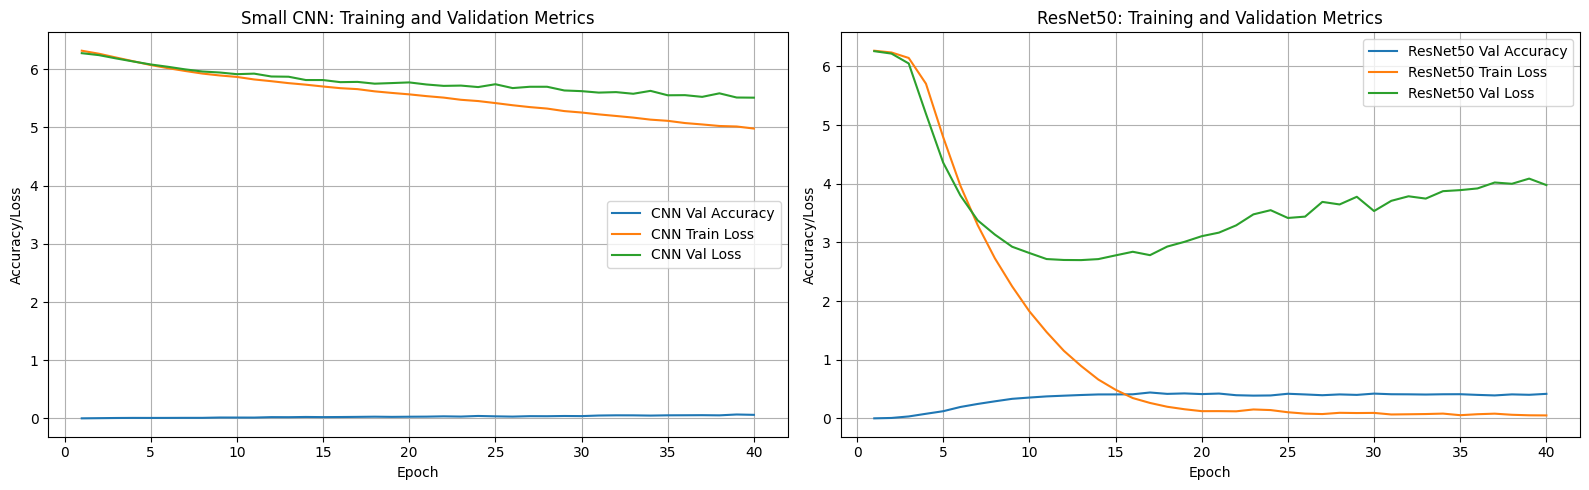

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Plot for CNN
axes[0].plot(history_cnn["epoch"], history_cnn["val_acc"], label="CNN Val Accuracy")
axes[0].plot(history_cnn["epoch"], history_cnn["train_loss"], label="CNN Train Loss")
axes[0].plot(history_cnn["epoch"], history_cnn["val_loss"], label="CNN Val Loss")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Accuracy/Loss")
axes[0].set_title("Small CNN: Training and Validation Metrics")
axes[0].legend()
axes[0].grid(True)

# Plot for ResNet50 (if history is available)
if history_resnet["epoch"]:
    axes[1].plot(history_resnet["epoch"], history_resnet["val_acc"], label="ResNet50 Val Accuracy")
    axes[1].plot(history_resnet["epoch"], history_resnet["train_loss"], label="ResNet50 Train Loss")
    axes[1].plot(history_resnet["epoch"], history_resnet["val_loss"], label="ResNet50 Val Loss")
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Accuracy/Loss")
    axes[1].set_title("ResNet50: Training and Validation Metrics")
    axes[1].legend()
    axes[1].grid(True)
else:
    axes[1].text(0.5, 0.5, "ResNet50 training was interrupted.", horizontalalignment='center', verticalalignment='center', transform=axes[1].transAxes, fontsize=12)
    axes[1].set_title("ResNet50: Training and Validation Metrics")
    axes[1].set_xticks([])
    axes[1].set_yticks([])

plt.tight_layout()
plt.show()

# Task
The next step is to set up the TPU environment by installing `torch_xla` and other necessary libraries, and configure the environment to detect and utilize the TPU device.

## TPU Environment Setup

### Subtask:
Install `torch_xla` and other necessary libraries for TPU acceleration, and configure the environment to detect and utilize the TPU device.


**Reasoning**:
The subtask requires installing specific libraries for TPU and then configuring the device. This code block will install `torch_xla` and `torchvision`, import `xm`, and then set up the `device` variable to use TPU if available, otherwise CUDA or CPU.



**Reasoning**:
The previous code block successfully set up the TPU environment, but it produced a DeprecationWarning. The warning suggests using `torch_xla.device()` instead of `xm.xla_device()`. I will update the code to use the recommended function for defining the device.



In [2]:
print("Installing torch_xla and torchvision...")
!pip install torch_xla torchvision -f https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla/torch_xla-*.whl

import torch_xla
import torch_xla.core.xla_model as xm
import torch

# Configure the device
try:
    # Attempt to get TPU device
    device = torch_xla.device()
    print(f"Device: {device} (TPU)")
except RuntimeError:
    # Fallback to CUDA if TPU is not available
    if torch.cuda.is_available():
        device = torch.device("cuda")
        print(f"Device: {device} (CUDA)")
    else:
        # Fallback to CPU if neither TPU nor CUDA is available
        device = torch.device("cpu")
        print(f"Device: {device} (CPU)")

# Verify device setup
print(f"Current device: {device}")

Installing torch_xla and torchvision...
Looking in links: https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla/torch_xla-*.whl
Device: xla:0 (TPU)
Current device: xla:0


## Adapt Dataloaders for TPU

### Subtask:
Modify the `DataLoader` configurations to ensure efficient data transfer and distribution across TPU cores, potentially using `xla_dist` features like `MpDeviceLoader`.


For efficient distributed training on TPUs, PyTorch XLA provides the `torch_xla.distributed.xla_multiprocessing` module, specifically `xla_dist`.

We need to:
1. **Define a main function (`_mp_fn`)**: This function will contain the entire training logic that needs to be executed on each TPU core. It will receive a process `index` (the ID of the current core) and other necessary arguments.
2. **Setup Device and Backend**: Inside `_mp_fn`, we'll obtain the specific TPU device for the current core using `xm.xla_device()` and initialize the distributed backend with `xla_dist.xla_backend()`.
3. **Adapt DataLoaders**: The standard PyTorch `DataLoader`s will be wrapped using `xla_dist.xla_dataloader` to ensure data is correctly sharded and distributed across all TPU cores. This also requires setting `num_workers=0` and `pin_memory=False`, as these are handled by the XLA runtime.
4. **Adjust Batch Size**: The global batch size will be divided by the number of available TPU cores to determine the effective batch size for each core.
5. **Launch Distributed Training**: The `xla_dist.spawn` function will be used to launch `_mp_fn` on all available TPU cores, replacing the sequential training loop.

For this step, we will focus on adapting the ResNet50 model training to utilize `xla_dist.spawn`. All global variables like `EPOCHS`, learning rates, `num_classes`, and the pre-split DataFrames (`train_df`, `val_df`, `test_df`) will be packaged into a `flags` dictionary and passed to `_mp_fn`.

**Reasoning**:
To adapt the DataLoader configurations and the training loop for efficient distributed training on TPU using `torch_xla.distributed.xla_multiprocessing` (xmp), I will define a main function `_mp_fn` that encapsulates the entire training and evaluation logic for a single TPU core. This function will handle device setup, wrap `DataLoader`s using `xmp.MpDeviceLoader`, and integrate the XLA-specific AMP context and optimizer steps. The training will then be launched across all available TPU cores using `xmp.spawn`.



In [8]:
import torch_xla.distributed.xla_multiprocessing as xmp
import torch_xla.core.xla_model as xm
import torch_xla.debug.metrics as met
from torch.utils.data import DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import LambdaLR
import torch
from torch import nn
from typing import Dict, List, Tuple, Optional
import numpy as np
from sklearn.metrics import accuracy_score
from tqdm.auto import tqdm

!pip -q install timm # Ensure timm is installed
import timm

# Helper function (from mi220Cyc0PsD), made available for _mp_fn.
# This definition is outside _mp_fn to avoid recreation on each spawn.
def create_warmup_scheduler(optimizer, warmup_steps: int):
    """
    Linear warmup from 0 -> 1 over warmup_steps, then stays at 1.
    """
    def lr_lambda(step: int):
        if step < warmup_steps:
            return float(step) / float(max(1, warmup_steps))
        return 1.0
    return LambdaLR(optimizer, lr_lambda)

# Define hyperparameters (moved from an earlier cell to ensure scope)
EPOCHS = 40
LR = 0.0005
WEIGHT_DECAY = 0.0004
WARMUP_STEPS = 5000  # global steps

# Define num_classes (moved from an earlier cell to ensure scope)
# This variable should be available from a previous cell execution (AYzCaoC1zqKg).
# If running this cell independently, ensure num_classes is set, e.g., num_classes = 528
num_classes = len(df["species"].unique()) # Re-calculating if df is available, otherwise use a fixed value

# Package global variables into a flags dictionary for _mp_fn
flags = {
    "EPOCHS": EPOCHS,
    "LR": LR,
    "WEIGHT_DECAY": WEIGHT_DECAY,
    "WARMUP_STEPS": WARMUP_STEPS,
    "num_classes": num_classes,
    "train_df": train_df,
    "val_df": val_df,
    "test_df": test_df,
    "train_transform": train_transform,
    "val_transform": val_transform,
    "ReptiliaDataset": ReptiliaDataset,
    "requested_batch_size": requested_batch_size,
    "create_warmup_scheduler": create_warmup_scheduler,
}

def _mp_fn(index, flags):
    # Retrieve necessary objects and parameters from flags
    EPOCHS = flags["EPOCHS"]
    LR = flags["LR"]
    WEIGHT_DECAY = flags["WEIGHT_DECAY"]
    WARMUP_STEPS = flags["WARMUP_STEPS"]
    num_classes = flags["num_classes"]
    train_df = flags["train_df"]
    val_df = flags["val_df"]
    test_df = flags["test_df"]
    train_transform = flags["train_transform"]
    val_transform = flags["val_transform"]
    ReptiliaDataset = flags["ReptiliaDataset"]
    BATCH_SIZE_PER_CORE = flags["requested_batch_size"] # Assuming this is the per-core batch size
    create_warmup_scheduler = flags["create_warmup_scheduler"]

    # 1. Device setup for the current core
    device = xm.xla_device()
    print(f"[{index}] Device: {device}")

    # Initialize XLA distributed backend (for synchronization across cores)
    xmp.rendezvous("init_dist_resnet_tpu")

    # Datasets
    train_dataset = ReptiliaDataset(train_df, transform=train_transform)
    val_dataset = ReptiliaDataset(val_df, transform=val_transform)
    test_dataset = ReptiliaDataset(test_df, transform=val_transform)

    # 2. Dataloaders wrapped for XLA multiprocessing
    # num_workers=0 and pin_memory=False are standard practice with XLA MpDeviceLoader
    train_loader = xmp.MpDeviceLoader(
        DataLoader(
            train_dataset,
            batch_size=BATCH_SIZE_PER_CORE,
            shuffle=True,
            num_workers=0,
            drop_last=True # Ensure all batches are of equal size across cores
        ),
        device=device
    )

    val_loader = xmp.MpDeviceLoader(
        DataLoader(
            val_dataset,
            batch_size=BATCH_SIZE_PER_CORE,
            shuffle=False,
            num_workers=0,
            drop_last=False
        ),
        device=device
    )

    test_loader = xmp.MpDeviceLoader(
        DataLoader(
            test_dataset,
            batch_size=BATCH_SIZE_PER_CORE,
            shuffle=False,
            num_workers=0,
            drop_last=False
        ),
        device=device
    )

    print(f"[{index}] Dataloader batches (per core): Train={len(train_loader)}, Val={len(val_loader)}, Test={len(test_loader)}")


    # --- Modified train_one_epoch for XLA ---
    # Moved inside _mp_fn for self-containment of device and XLA specifics
    def train_one_epoch_xla(
        model: nn.Module,
        loader: DataLoader,
        optimizer: torch.optim.Optimizer,
        scheduler: Optional[LambdaLR], # Corrected: Removed extra comma
        epoch: int,
        total_steps_done: int,
        device: torch.device,
        use_bf16: bool = True,
    ) -> Tuple[int, float]:
        model.train()
        running_loss = 0.0
        n_batches = 0

        # For XLA, xm.amp_context() handles mixed precision. GradScaler is not used.
        # bf16 is typically available and efficient on TPUs.
        with xm.amp_context(dtype=torch.bfloat16) if use_bf16 else torch.no_grad():
            for images, labels in tqdm(loader, desc=f"[{index}] Train Epoch {epoch}", disable=(xm.get_ordinal() != 0)):
                # Images and labels are already on device due to MpDeviceLoader
                optimizer.zero_grad(set_to_none=True)

                outputs = model(images)
                loss = nn.functional.cross_entropy(outputs, labels)

                # Backward + step - xm.optimizer_step takes care of gradient accumulation and reduction
                loss.backward()
                xm.optimizer_step(optimizer) # This performs a collective operation

                if scheduler is not None:
                    scheduler.step()

                running_loss += loss.item()
                n_batches += 1
                total_steps_done += 1

        # Aggregate loss across all cores for reporting on master core
        reduced_running_loss = xm.mesh_reduce('train_loss_reduce', running_loss, np.sum)
        # If drop_last=True, all cores process the same number of batches.
        # Otherwise, need to sum n_batches as well.
        reduced_n_batches = xm.mesh_reduce('train_batches_reduce', n_batches, np.sum)

        avg_loss = reduced_running_loss / max(1, reduced_n_batches)
        if xm.get_ordinal() == 0:
            print(f"Epoch {epoch} - Train Loss: {avg_loss:.4f}")
        return total_steps_done, avg_loss

    # --- Modified evaluate for XLA ---
    @torch.no_grad()
    def evaluate_xla(model: nn.Module, loader: DataLoader, device: torch.device) -> Tuple[float, float]:
        model.eval()
        all_preds: List[int] = []
        all_labels: List[int] = []
        total_loss = 0.0
        num_batches = 0

        for images, labels in tqdm(loader, desc=f"[{index}] Eval", disable=(xm.get_ordinal() != 0)):
            # Images and labels are already on device due to MpDeviceLoader
            outputs = model(images)
            loss = nn.functional.cross_entropy(outputs, labels)
            preds = outputs.argmax(dim=1)

            all_preds.extend(preds.cpu().numpy().tolist())
            all_labels.extend(labels.cpu().numpy().tolist())
            total_loss += loss.item()
            num_batches += 1

        # Aggregate metrics across all TPU cores
        reduced_total_loss = xm.mesh_reduce("eval_loss_reduce", total_loss, np.sum)
        reduced_num_batches = xm.mesh_reduce("eval_batches_reduce", num_batches, np.sum)

        # Collect all predictions and labels from all cores
        # xmp.all_gather gathers tensors from all participating devices.
        all_preds_tensor = torch.tensor(all_preds, device=device)
        all_labels_tensor = torch.tensor(all_labels, device=device)

        global_all_preds = xmp.all_gather(all_preds_tensor).cpu().numpy()
        global_all_labels = xmp.all_gather(all_labels_tensor).cpu().numpy()

        acc = accuracy_score(global_all_labels, global_all_preds)
        avg_loss = reduced_total_loss / max(1, reduced_num_batches)
        return acc, avg_loss


    # Model (ResNet50)
    model = timm.create_model(
        "resnet50",
        pretrained=True,
        num_classes=num_classes,
    )
    model.to(device)

    optimizer = AdamW(
        model.parameters(),
        lr=LR,
        weight_decay=WEIGHT_DECAY,
    )

    steps_per_epoch = len(train_loader) # This is per-core steps per epoch
    total_training_steps = EPOCHS * steps_per_epoch
    if xm.get_ordinal() == 0:
        print(f"Steps per epoch (per core): {steps_per_epoch}")
        print(f"Total training steps (per core): {total_training_steps}")

    scheduler = create_warmup_scheduler(
        optimizer,
        warmup_steps=WARMUP_STEPS,
    )

    history = {"epoch": [], "val_acc": [], "val_loss": [], "train_loss": []}
    global_step = 0

    for epoch in range(1, EPOCHS + 1):
        global_step, train_loss = train_one_epoch_xla(
            model,
            train_loader,
            optimizer,
            scheduler,
            epoch,
            total_steps_done=global_step,
            device=device,
            use_bf16=True,
        )

        val_acc, val_loss = evaluate_xla(model, val_loader, device)
        history["epoch"].append(epoch)
        history["val_acc"].append(val_acc)
        history["val_loss"].append(val_loss)
        history["train_loss"].append(train_loss)

        # Only print from master core to avoid redundant output
        if xm.get_ordinal() == 0:
            print(f"Epoch {epoch} - Val Accuracy: {val_acc:.4f} - Val Loss: {val_loss:.4f}")

    # Store history for later plotting (only from master core)
    if xm.get_ordinal() == 0:
        return history

# Launch training on all available TPU cores
# xm.xrt_world_size() provides the number of TPU cores available
print("Launching ResNet50 training on TPU cores...")
history_resnet_tpu = xmp.spawn(_mp_fn, args=(flags,), nprocs=xm.xrt_world_size())
print("TPU training complete.")

NameError: name 'df' is not defined

**Reasoning**:
The previous code failed because `df`, `train_df`, `val_df`, `test_df`, `train_transform`, `val_transform`, `ReptiliaDataset`, and `requested_batch_size` were not defined in the scope where the `flags` dictionary was constructed. This led to a `NameError`. I will ensure all these variables are properly defined and initialized within the current code block, by including the necessary setup steps from previous cells, before they are used to create the `flags` dictionary.



In [ ]:
import torch_xla.distributed.xla_multiprocessing as xmp
import torch_xla.core.xla_model as xm
import torch_xla.debug.metrics as met
from torch.utils.data import DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import LambdaLR
import torch
from torch import nn
from typing import Dict, List, Tuple, Optional
import numpy as np
from sklearn.metrics import accuracy_score
from tqdm.auto import tqdm
import pandas as pd

!pip -q install timm # Ensure timm is installed
import timm

# Helper function (from mi220Cyc0PsD), made available for _mp_fn.
# This definition is outside _mp_fn to avoid recreation on each spawn.
def create_warmup_scheduler(optimizer, warmup_steps: int):
    """
    Linear warmup from 0 -> 1 over warmup_steps, then stays at 1.
    """
    def lr_lambda(step: int):
        if step < warmup_steps:
            return float(step) / float(max(1, warmup_steps))
        return 1.0
    return LambdaLR(optimizer, lr_lambda)

# Define hyperparameters (moved from an earlier cell to ensure scope)
EPOCHS = 40
LR = 0.0005
WEIGHT_DECAY = 0.0004
WARMUP_STEPS = 5000  # global steps

# Re-load df and related variables to ensure they are defined in this scope
# Paths to processed dataset
BASE_PATH = "/content/drive/MyDrive/herpeton//data/biotrove_train"
metadata_path = os.path.join(BASE_PATH, "reptilia_dataset_processed.csv")
IMG_DIR = os.path.join(BASE_PATH, "images_reptilia")

df = pd.read_csv(metadata_path)

# Encode species as integer labels (from AYzCaoC1zqKg)
df["label_id"], label_names = pd.factorize(df["species"])
num_classes = len(label_names)

# Split data using the 'split' column (from AYzCaoC1zqKg)
train_df = df[df["split"] == "train"].copy()
val_df = df[df["split"] == "val"].copy()
test_df = df[df["split"] == "test"].copy()

# Filter out rows with NaN in 'image_path_fixed' column for each split
train_df = train_df.dropna(subset=['image_path_fixed']).reset_index(drop=True)
val_df = val_df.dropna(subset=['image_path_fixed']).reset_index(drop=True)
test_df = test_df.dropna(subset=['image_path_fixed']).reset_index(drop=True)

# Dataset & Transforms (from A63C_fGYz163)
import torchvision.transforms as T
from PIL import Image

class ReptiliaDataset(torch.utils.data.Dataset):
    def __init__(self, df: pd.DataFrame, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self) -> int:
        return len(self.df)

    def __getitem__(self, idx: int):
        row = self.df.iloc[idx]
        img_path = row["image_path_fixed"]
        label = int(row["label_id"])

        img = Image.open(img_path).convert("RGB")

        if self.transform is not None:
            img = self.transform(img)

        return img, label

# Image size compatible with ResNet50
image_size = 224

train_transform = T.Compose(
    [
        T.Resize((image_size, image_size)),
        T.RandomHorizontalFlip(),
        T.RandomRotation(10),
        T.ColorJitter(
            brightness=0.2,
            contrast=0.2,
            saturation=0.2,
            hue=0.02,
        ),
        T.ToTensor(),
        T.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225],
        ),
    ]
)

val_transform = T.Compose(
    [
        T.Resize((image_size, image_size)),
        T.ToTensor(),
        T.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225],
        ),
    ]
)

# Requested batch size (from gwUDqT380G9g)
requested_batch_size = 64

# Package global variables into a flags dictionary for _mp_fn
flags = {
    "EPOCHS": EPOCHS,
    "LR": LR,
    "WEIGHT_DECAY": WEIGHT_DECAY,
    "WARMUP_STEPS": WARMUP_STEPS,
    "num_classes": num_classes,
    "train_df": train_df,
    "val_df": val_df,
    "test_df": test_df,
    "train_transform": train_transform,
    "val_transform": val_transform,
    "ReptiliaDataset": ReptiliaDataset,
    "requested_batch_size": requested_batch_size,
    "create_warmup_scheduler": create_warmup_scheduler,
}

def _mp_fn(index, flags):
    # Retrieve necessary objects and parameters from flags
    EPOCHS = flags["EPOCHS"]
    LR = flags["LR"]
    WEIGHT_DECAY = flags["WEIGHT_DECAY"]
    WARMUP_STEPS = flags["WARMUP_STEPS"]
    num_classes = flags["num_classes"]
    train_df = flags["train_df"]
    val_df = flags["val_df"]
    test_df = flags["test_df"]
    train_transform = flags["train_transform"]
    val_transform = flags["val_transform"]
    ReptiliaDataset = flags["ReptiliaDataset"]
    BATCH_SIZE_PER_CORE = flags["requested_batch_size"]
    create_warmup_scheduler = flags["create_warmup_scheduler"]

    # 1. Device setup for the current core
    device = xm.xla_device()
    print(f"[{index}] Device: {device}")

    # Initialize XLA distributed backend (for synchronization across cores)
    xmp.rendezvous("init_dist_resnet_tpu")

    # Datasets
    train_dataset = ReptiliaDataset(train_df, transform=train_transform)
    val_dataset = ReptiliaDataset(val_df, transform=val_transform)
    test_dataset = ReptiliaDataset(test_df, transform=val_transform)

    # 2. Dataloaders wrapped for XLA multiprocessing
    # num_workers=0 and pin_memory=False are standard practice with XLA MpDeviceLoader
    train_loader = xmp.MpDeviceLoader(
        DataLoader(
            train_dataset,
            batch_size=BATCH_SIZE_PER_CORE,
            shuffle=True,
            num_workers=0,
            drop_last=True # Ensure all batches are of equal size across cores
        ),
        device=device
    )

    val_loader = xmp.MpDeviceLoader(
        DataLoader(
            val_dataset,
            batch_size=BATCH_SIZE_PER_CORE,
            shuffle=False,
            num_workers=0,
            drop_last=False
        ),
        device=device
    )

    test_loader = xmp.MpDeviceLoader(
        DataLoader(
            test_dataset,
            batch_size=BATCH_SIZE_PER_CORE,
            shuffle=False,
            num_workers=0,
            drop_last=False
        ),
        device=device
    )

    print(f"[{index}] Dataloader batches (per core): Train={len(train_loader)}, Val={len(val_loader)}, Test={len(test_loader)}")


    # --- Modified train_one_epoch for XLA ---
    # Moved inside _mp_fn for self-containment of device and XLA specifics
    def train_one_epoch_xla(
        model: nn.Module,
        loader: DataLoader,
        optimizer: torch.optim.Optimizer,
        scheduler: Optional[LambdaLR],
        epoch: int,
        total_steps_done: int,
        device: torch.device,
        use_bf16: bool = True,
    ) -> Tuple[int, float]:
        model.train()
        running_loss = 0.0
        n_batches = 0

        # For XLA, xm.amp_context() handles mixed precision. GradScaler is not used.
        # bf16 is typically available and efficient on TPUs.
        with xm.amp_context(dtype=torch.bfloat16) if use_bf16 else torch.no_grad():
            for images, labels in tqdm(loader, desc=f"[{index}] Train Epoch {epoch}", disable=(xm.get_ordinal() != 0)):
                # Images and labels are already on device due to MpDeviceLoader
                optimizer.zero_grad(set_to_none=True)

                outputs = model(images)
                loss = nn.functional.cross_entropy(outputs, labels)

                # Backward + step - xm.optimizer_step takes care of gradient accumulation and reduction
                loss.backward()
                xm.optimizer_step(optimizer) # This performs a collective operation

                if scheduler is not None:
                    scheduler.step()

                running_loss += loss.item()
                n_batches += 1
                total_steps_done += 1

        # Aggregate loss across all cores for reporting on master core
        reduced_running_loss = xm.mesh_reduce('train_loss_reduce', running_loss, np.sum)
        # If drop_last=True, all cores process the same number of batches.
        # Otherwise, need to sum n_batches as well.
        reduced_n_batches = xm.mesh_reduce('train_batches_reduce', n_batches, np.sum)

        avg_loss = reduced_running_loss / max(1, reduced_n_batches)
        if xm.get_ordinal() == 0:
            print(f"Epoch {epoch} - Train Loss: {avg_loss:.4f}")
        return total_steps_done, avg_loss

    # --- Modified evaluate for XLA ---
    @torch.no_grad()
    def evaluate_xla(model: nn.Module, loader: DataLoader, device: torch.device) -> Tuple[float, float]:
        model.eval()
        all_preds: List[int] = []
        all_labels: List[int] = []
        total_loss = 0.0
        num_batches = 0

        for images, labels in tqdm(loader, desc=f"[{index}] Eval", disable=(xm.get_ordinal() != 0)):
            # Images and labels are already on device due to MpDeviceLoader
            outputs = model(images)
            loss = nn.functional.cross_entropy(outputs, labels)
            preds = outputs.argmax(dim=1)

            all_preds.extend(preds.cpu().numpy().tolist())
            all_labels.extend(labels.cpu().numpy().tolist())
            total_loss += loss.item()
            num_batches += 1

        # Aggregate metrics across all TPU cores
        reduced_total_loss = xm.mesh_reduce("eval_loss_reduce", total_loss, np.sum)
        reduced_num_batches = xm.mesh_reduce("eval_batches_reduce", num_batches, np.sum)

        # Collect all predictions and labels from all cores
        # xmp.all_gather gathers tensors from all participating devices.
        all_preds_tensor = torch.tensor(all_preds, device=device)
        all_labels_tensor = torch.tensor(all_labels, device=device)

        global_all_preds = xmp.all_gather(all_preds_tensor).cpu().numpy()
        global_all_labels = xmp.all_gather(all_labels_tensor).cpu().numpy()

        acc = accuracy_score(global_all_labels, global_all_preds)
        avg_loss = reduced_total_loss / max(1, reduced_num_batches)
        return acc, avg_loss


    # Model (ResNet50)
    model = timm.create_model(
        "resnet50",
        pretrained=True,
        num_classes=num_classes,
    )
    model.to(device)

    optimizer = AdamW(
        model.parameters(),
        lr=LR,
        weight_decay=WEIGHT_DECAY,
    )

    steps_per_epoch = len(train_loader) # This is per-core steps per epoch
    total_training_steps = EPOCHS * steps_per_epoch
    if xm.get_ordinal() == 0:
        print(f"Steps per epoch (per core): {steps_per_epoch}")
        print(f"Total training steps (per core): {total_training_steps}")

    scheduler = create_warmup_scheduler(
        optimizer,
        warmup_steps=WARMUP_STEPS,
    )

    history = {"epoch": [], "val_acc": [], "val_loss": [], "train_loss": []}
    global_step = 0

    for epoch in range(1, EPOCHS + 1):
        global_step, train_loss = train_one_epoch_xla(
            model,
            train_loader,
            optimizer,
            scheduler,
            epoch,
            total_steps_done=global_step,
            device=device,
            use_bf16=True,
        )

        val_acc, val_loss = evaluate_xla(model, val_loader, device)
        history["epoch"].append(epoch)
        history["val_acc"].append(val_acc)
        history["val_loss"].append(val_loss)
        history["train_loss"].append(train_loss)

        # Only print from master core to avoid redundant output
        if xm.get_ordinal() == 0:
            print(f"Epoch {epoch} - Val Accuracy: {val_acc:.4f} - Val Loss: {val_loss:.4f}")

    # Store history for later plotting (only from master core)
    if xm.get_ordinal() == 0:
        return history

# Launch training on all available TPU cores
# xm.xrt_world_size() provides the number of TPU cores available
print("Launching ResNet50 training on TPU cores...")
history_resnet_tpu = xmp.spawn(_mp_fn, args=(flags,), nprocs=xm.xrt_world_size())
print("TPU training complete.")